In [1]:
from __future__ import annotations
from itertools import chain
from collections import defaultdict
import os
from build import get_names
import numpy as np
import networkx as nx
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import re
import networkx as nx
import networkx.algorithms.community as nx_comm
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

datapath = "../data"
localdatapath = "../local_data"

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["figure.dpi"]  = 300

In [2]:
df = pd.read_csv(os.path.join(localdatapath, "book.csv"), header=0, index_col=0)
df["names"] = df.apply(lambda r: eval(r["names"]), axis=1)
df['selftext'] = df['text']
df = df.drop(['text'], axis = 1)
df.iloc[3]

book                                                        0
title                                                DAENERYS
names       [Daenerys Targaryen, Jorah Mormont, Viserys Ta...
selftext    DAENERYS\n\n\n\n\n\nHer brother held the gown ...
Name: 3, dtype: object

In [3]:
df_reddit = pd.read_csv(os.path.join(localdatapath, "asoiaf_data_cleaned.csv"), header=0, index_col=0)
df_reddit["names"] = df_reddit.apply(lambda r: eval(r["names"]), axis=1)
df_reddit.iloc[3]

title            (Spoilers extended)The Night King needs Bran
score                                                       3
created                                            1555184407
author                                                 dikziw
selftext    Ever since the episode where Bran is “marked” ...
names       [Brandon 'Bran' Stark, Jon Snow, Brandon 'Bran...
Name: 10, dtype: object

In [16]:
url = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
num = r"\d"
punct = r"'!?.*&_#\-=\\·\[]“”"
stop_ord = list(stopwords.words("english")) 
stop_ord.extend(['would' , 'could', 'one', 'ser', 'said','…','“i','“the'])
stop_ord = set(stop_ord)
stops = set(stopwords.words("english"))

def tokenize_sub(row):
    """ 
    Takes in a row of the GME submissions in Pandas dataframe and splits the selftext into tokens that are lower-cased
    and filtered for numbers, stop words, punctuations and URL's. We do not perform stemming and lemmatization as
    the full words are easier to understand in analysis than just using stems.
    """
    sub = row["selftext"]
    tokens = list()
    for w in sub.split():
        w = w.strip().lower()
        if re.search(num, w) or re.search(punct, w) or re.search(url, w) or w in stop_ord:
            continue
        tokens.append(w)
    return tokens

df_reddit["tokens"] = df_reddit.apply(tokenize_sub, axis=1)
df["tokens"] = df.apply(tokenize_sub, axis=1)

In [17]:
namedict  = get_names("../data")
L = [name for name in namedict.values()]
nameset  = [name.lower() for name in list(chain(*L))]
nameset  = set(nameset)

In [18]:
docs = {k: list() for k in list(namedict)}
for names, tokens in zip(df["names"], df["tokens"]):
    if names:
        
        for i in range(len(names)):
            docs[names[i]] += tokens


In [19]:
chosen = ("Daenerys Targaryen", "Eddard 'Ned' Stark", "Jon Snow", "Jaime Lannister", "Jorah Mormont")
N = len(chosen)
doc_tfs = dict()
word_docs = defaultdict(lambda: set())
for stock in chosen:
    doc = docs[stock]
    M = len(doc)
    tfs = dict()
    for w in set(doc):
        tfs[w] = doc.count(w) / M
        word_docs[w].add(stock)
    print(
        f"Top 5 TF-terms for {stock.upper()}: \t" + ", ".join(
            list(reversed(sorted(tfs, key=tfs.get)))[:5]
        )
    )
    doc_tfs[stock] = tfs
doc_freqs = {w: len(d) for w, d in word_docs.items()}
doc_idfs = {
    stock: {w: np.log(N/(doc_freqs[w]+1)) for w in set(docs[stock])} 
        for stock in chosen
    }

Top 5 TF-terms for DAENERYS TARGARYEN: 	dany, man, back, like, old
Top 5 TF-terms for EDDARD 'NED' STARK: 	lord, jon, man, like, men
Top 5 TF-terms for JON SNOW: 	lord, jon, man, like, men
Top 5 TF-terms for JAIME LANNISTER: 	lord, tyrion, man, jaime, like
Top 5 TF-terms for JORAH MORMONT: 	dany, man, back, jorah, old


In [20]:
doc_tf_idf = {
    stock: {w: doc_tfs[stock][w] * doc_idfs[stock][w] for w in set(docs[stock])} 
        for stock in chosen
    }

for stock in chosen:
    tf_idf = doc_tf_idf[stock]
    print(f"Top 10 terms for {stock.upper()}")
    print(
        f"\tUsing TF:\t" + ", ".join(
            list(reversed(sorted(doc_tfs[stock], key=doc_tfs[stock].get)))[:10]
        )
    )
    print(
        f"\tUsing TF-IDF:\t" + ", ".join(
            list(reversed(sorted(tf_idf, key=tf_idf.get)))[:10]
        )
    )

Top 10 terms for DAENERYS TARGARYEN
	Using TF:	dany, man, back, like, old, men, even, made, told, never
	Using TF-IDF:	gerris, hotah, belwas, cletus, drinkwater, astapori, armen, alleras, quentyn., quentyn’s
Top 10 terms for EDDARD 'NED' STARK
	Using TF:	lord, jon, man, like, men, him., back, even, never, said.
	Using TF-IDF:	asha, brienne, ygritte, ramsay, bronn, reek, reek,, tormund, magnar, thenns
Top 10 terms for JON SNOW
	Using TF:	lord, jon, man, like, men, back, him., even, old, never
	Using TF-IDF:	tormund, brienne, ygritte, asha, chett, magnar, ramsay, meera, varamyr, thenns
Top 10 terms for JAIME LANNISTER
	Using TF:	lord, tyrion, man, jaime, like, back, him., never, “you, men
	Using TF-IDF:	brienne, bronn, podrick, crabb, cleos, ilyn, creighton, hyle, osney, addam
Top 10 terms for JORAH MORMONT
	Using TF:	dany, man, back, jorah, old, like, told, men, even, “you
	Using TF-IDF:	belwas, astapori, cleon, kraznys, arstan, whitebeard, groleo, nakloz, drogon’s, craster


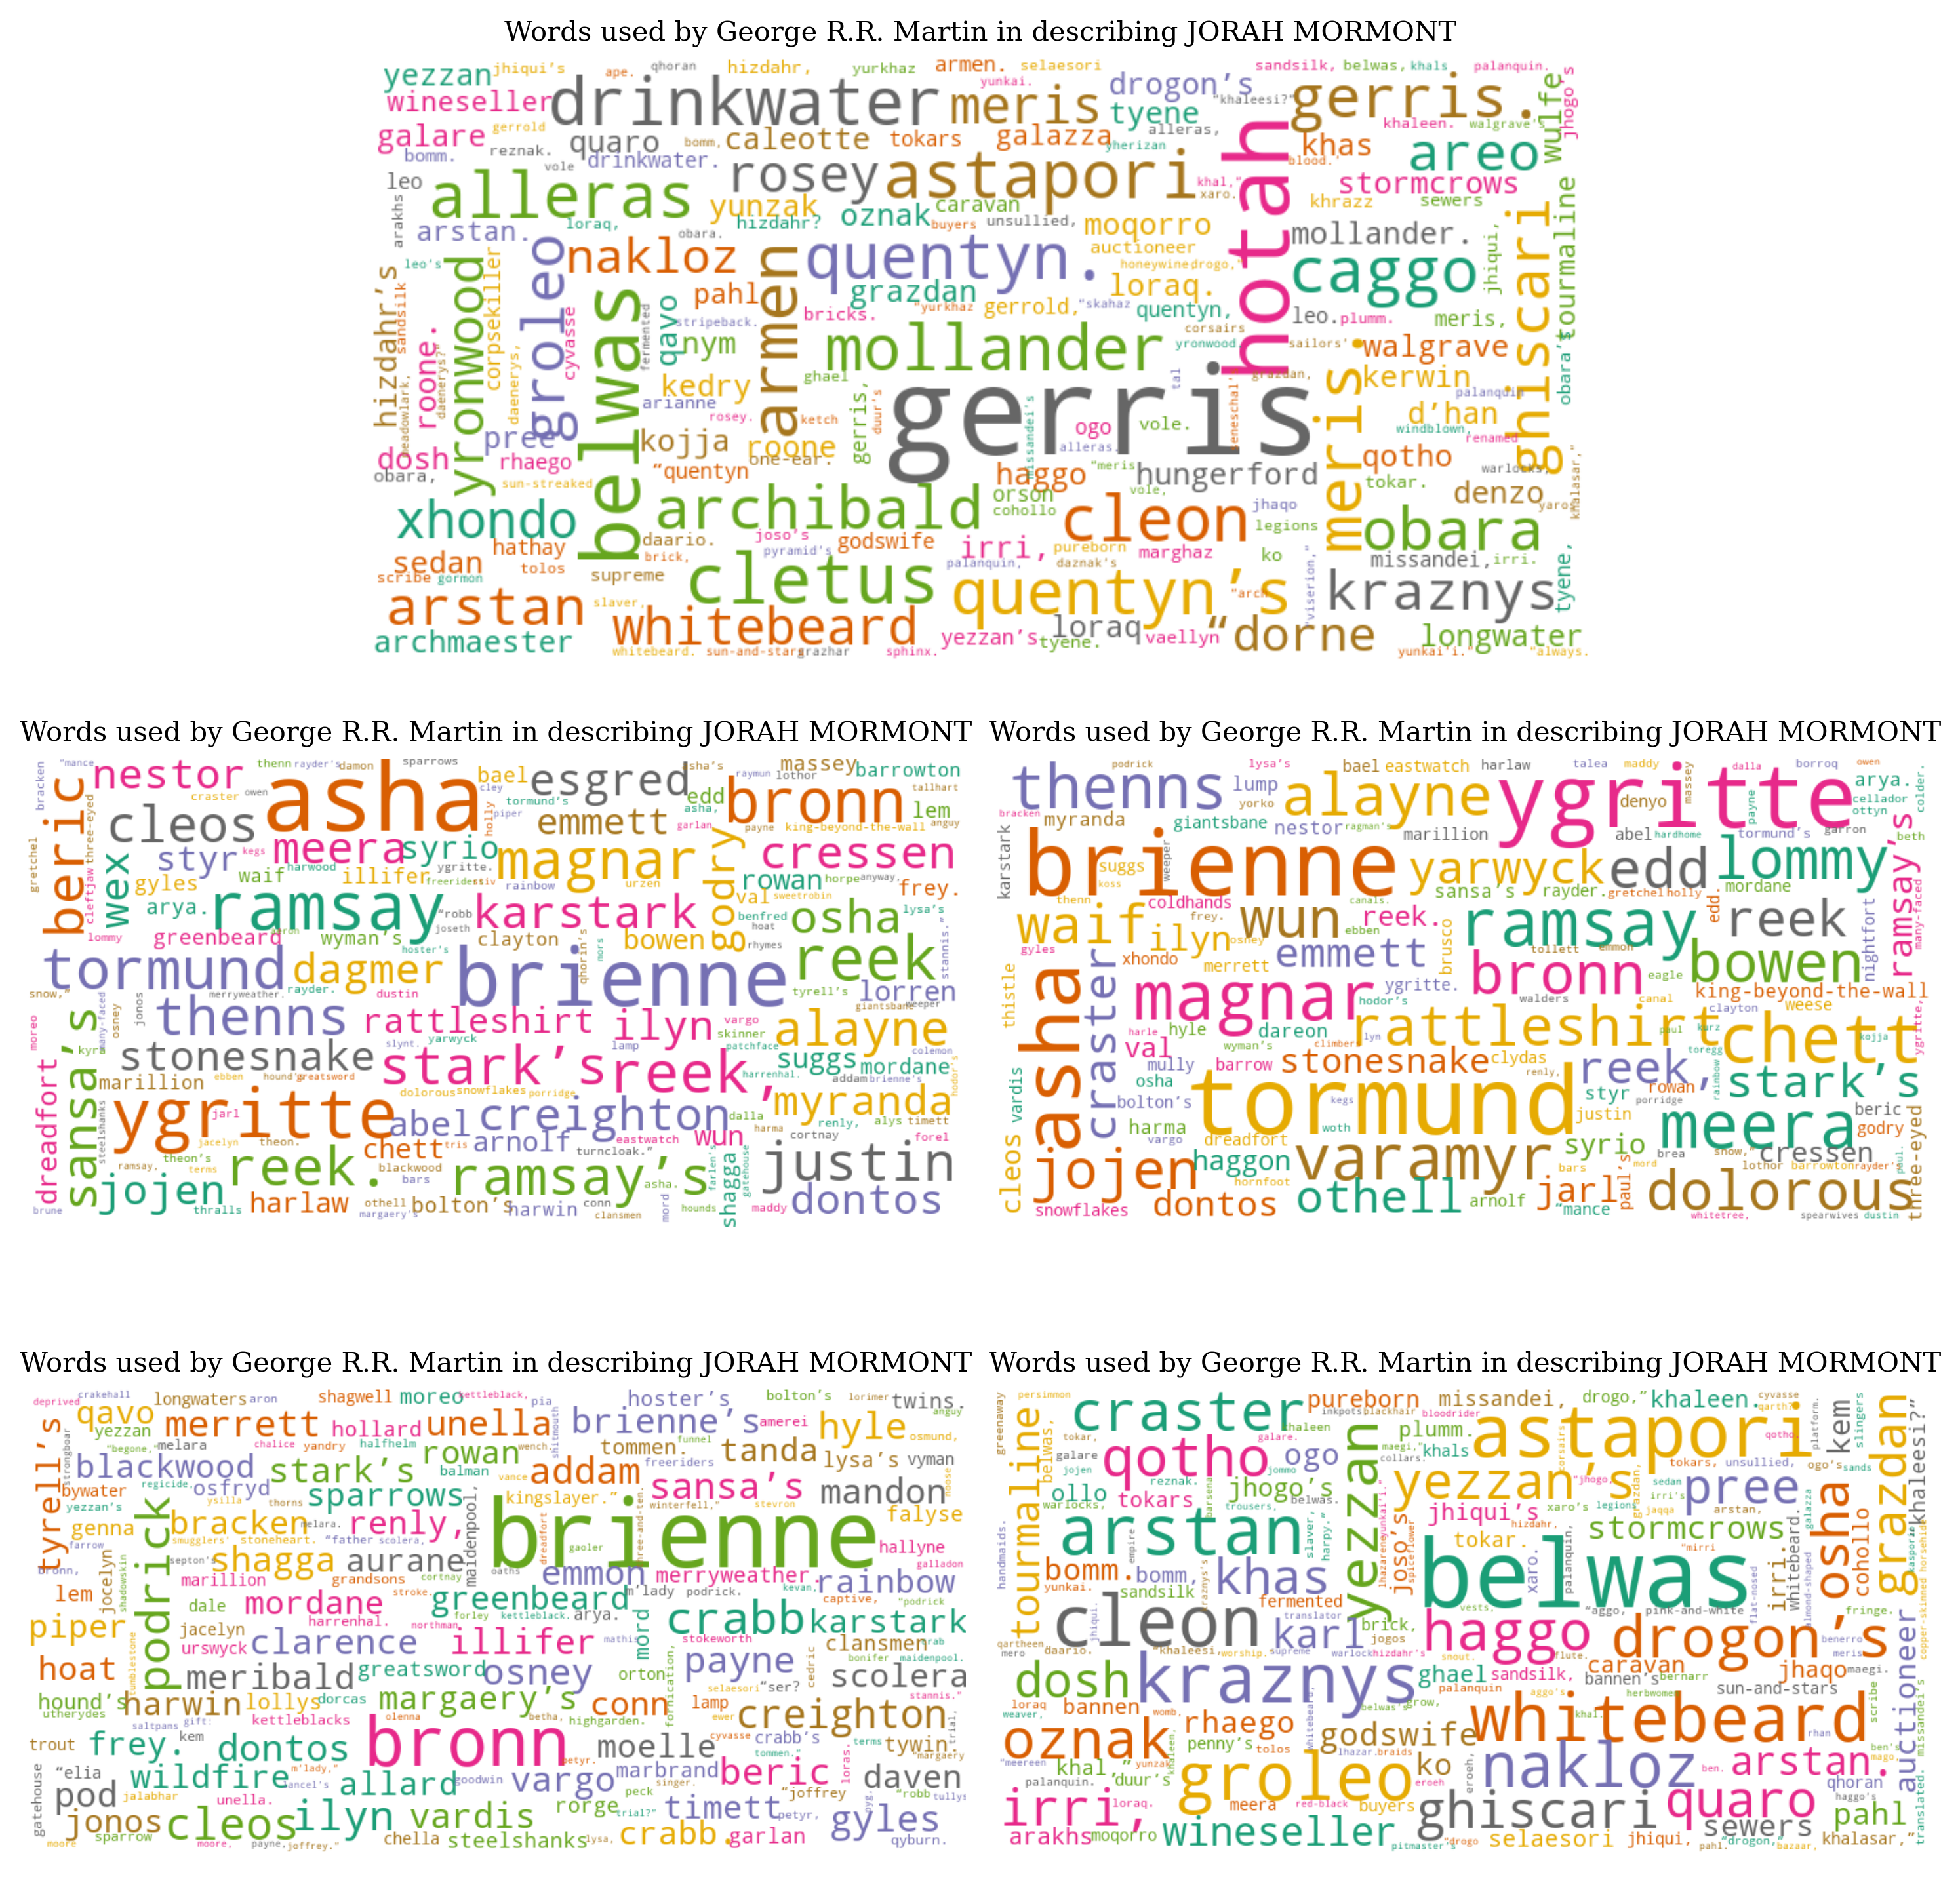

In [21]:
fig = plt.figure(figsize=(10, 10))
axes = [fig.add_subplot(3, 1, 1)]
for i in range(4): axes.append(fig.add_subplot(3, 2, i+3))

for name, ax in zip(chosen, axes):
    wordcloud = WordCloud(
        max_font_size=40,
        scale = 2,
        background_color="white",
        colormap = "Dark2",
    ).generate_from_frequencies(doc_tf_idf[name])
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Words used by George R.R. Martin in describing {stock.upper()}", fontsize=10)
plt.tight_layout()
plt.show()